In [ ]:
# Full pipeline

from torch.utils.data import *
from lircst_ana_dataset import LircstAnaDataset
from torch import Generator

dataset = LircstAnaDataset('/home/samnub/dev/lircst-ana/data/')

rand_generator = Generator().manual_seed(42) # The meaning of life, the universe and everything

dataset_train, dataset_valid, dataset_test = random_split(dataset, [0.8, 0.1, 0.1], generator=rand_generator)

print(f"Train set size: {len(dataset_train)}")
print(f"Validation set size: {len(dataset_valid)}")
print(f"Test set size: {len(dataset_test)}")


# Setup Diffusion modules
import pytorch_lightning as pl
from Diffusion.EMA import EMA

train_mode: bool = True
test_afterward: bool = True

#=================================================================================
# Encoded Conditional Diffusion
from encoded_conditional_diffusion import ECDiffusion

model_ECD = ECDiffusion(
    train_dataset=dataset_train,
    valid_dataset=dataset_valid,
    test_dataset=dataset_test,
    lr=1e-4,
    batch_size=16,
    physics=True,  # Use physics-based loss
)

if not train_mode:
    model_ECD = ECDiffusion.load_from_checkpoint("/home/samnub/dev/lircst-diffusion/src/lightning_logs/version_19/checkpoints/epoch=199-step=185400.ckpt",
                                            train_dataset=dataset_train,
                                            valid_dataset=dataset_valid,
                                            test_dataset=dataset_test,
                                            lr=1e-4,
                                            batch_size=16,)

trainer_ECD = pl.Trainer(
    max_steps=2e5,
    callbacks=[EMA(0.9999)],
    accelerator='gpu',
    devices=[0],
    check_val_every_n_epoch=1000,
    num_sanity_val_steps=0,  # Disable sanity check on dataloader
)
'''
#=================================================================================
# Encoded Conditional Latent Diffusion
from encoded_conditional_latent_diffusion import ECLDiffusion
model_ECLD = ECLDiffusion(
    train_dataset=dataset_train,
    valid_dataset=dataset_valid,
    test_dataset=dataset_test,
    lr=1e-4,
    batch_size=16,
)

if not train_mode:
    model_ECLD = ECLDiffusion.load_from_checkpoint("/home/samnub/dev/lircst-diffusion/src/lightning_logs/version_20/checkpoints/epoch=199-step=185400.ckpt",
                                            train_dataset=dataset_train,
                                            valid_dataset=dataset_valid,
                                            test_dataset=dataset_test,
                                            lr=1e-4,
                                            batch_size=16,)

trainer_ECLD = pl.Trainer(
    max_steps=2e5,
    callbacks=[EMA(0.9999)],
    accelerator='gpu',
    devices=[0],
    check_val_every_n_epoch=1000,
)
'''
#=================================================================================

if train_mode:
    # Train the models
    trainer_ECD.fit(model_ECD)
    #trainer_ECLD.fit(model_ECLD)

if test_afterward:
    # Test the models
    trainer_ECD.test(model_ECD)
    #trainer_ECLD.test(model_ECLD)

Random dataset index: 17713


diffusion sampling: 100%|██████████| 1000/1000 [4:09:42<00:00, 14.98s/it] 


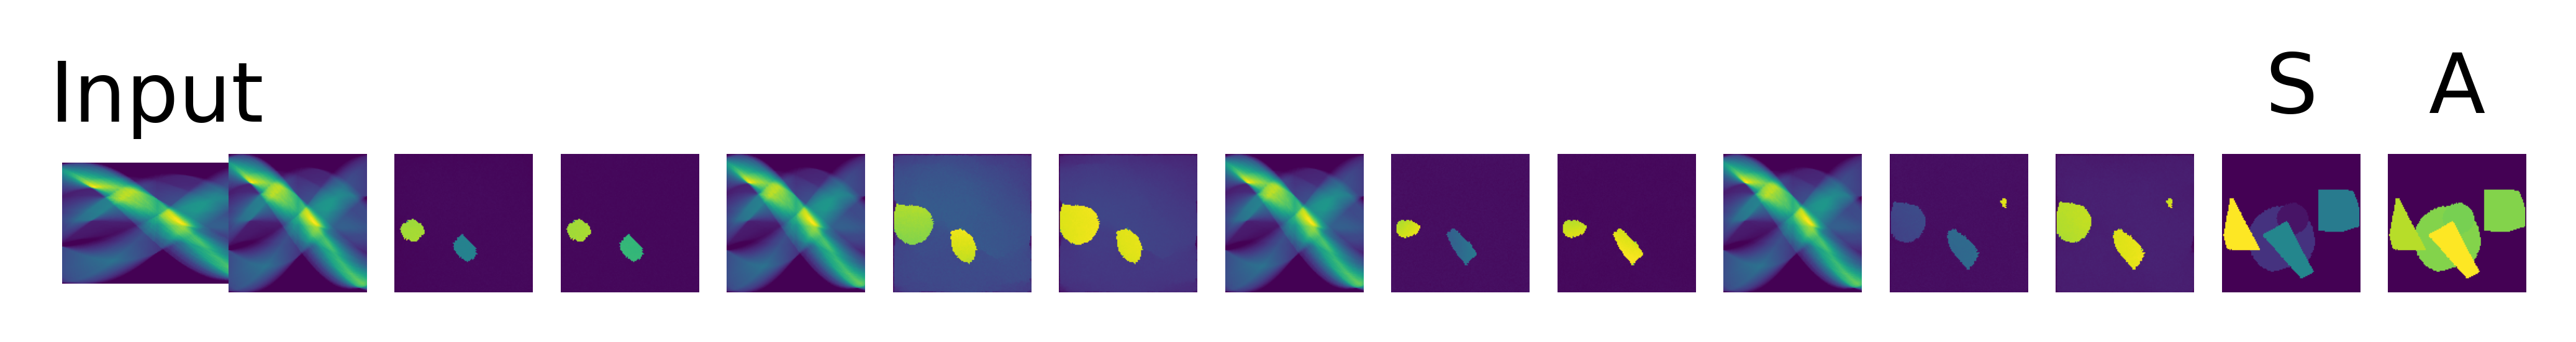

SSIM, PSNR:
Scatter channel: (np.float64(0.6501903498081892), np.float64(12.493670497105736))
Attenuation channel: (np.float64(0.4148825894365641), np.float64(6.826461518748439))
Scatter channel: (np.float64(0.5838729276618859), np.float64(12.830803705594715))
Attenuation channel: (np.float64(0.3634688099327867), np.float64(8.373358018227194))
Scatter channel: (np.float64(0.641473263970745), np.float64(11.147869218413168))
Attenuation channel: (np.float64(0.4204525424683637), np.float64(6.810062304492264))
Scatter channel: (np.float64(0.6195192102880647), np.float64(11.650874033834459))
Attenuation channel: (np.float64(0.4226810589942464), np.float64(8.027729140830086))


diffusion sampling: 100%|██████████| 1000/1000 [18:56<00:00,  1.14s/it] 


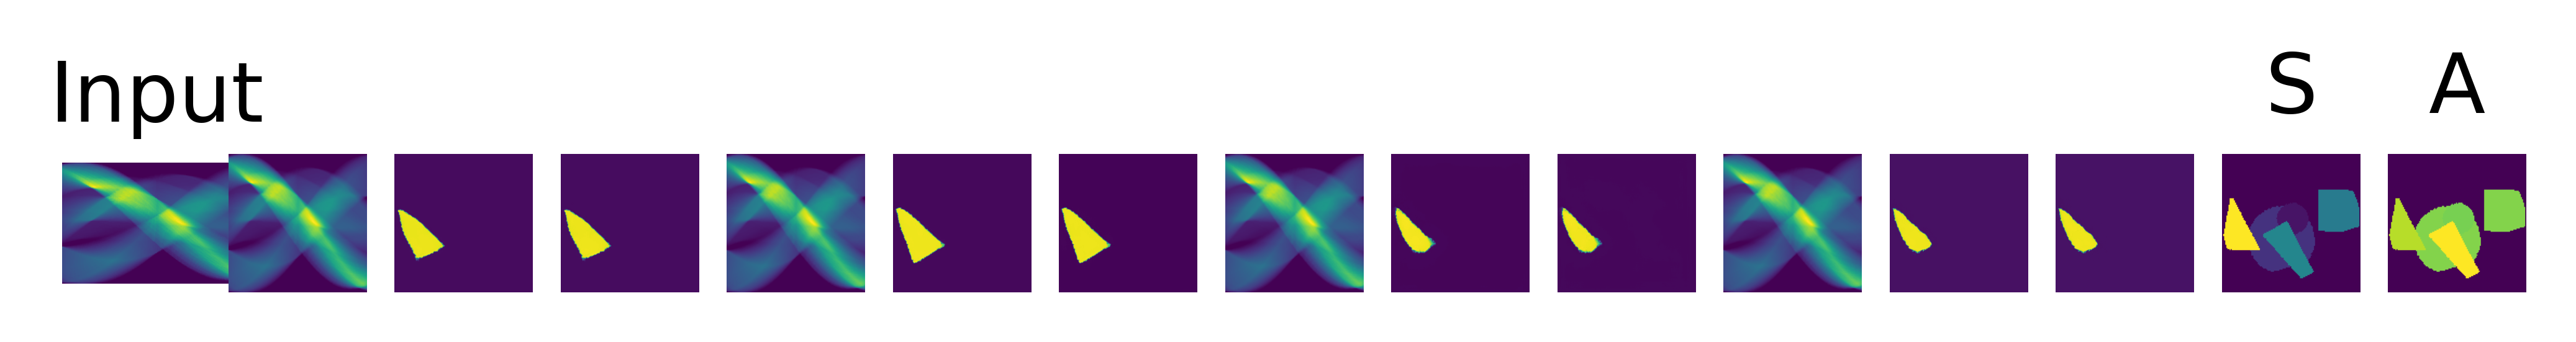

SSIM, PSNR:
Scatter channel: (np.float64(0.010254022328170418), np.float64(6.992833621233546))
Attenuation channel: (np.float64(0.0017454691912975923), np.float64(6.735569029914271))
Scatter channel: (np.float64(0.006405112621765254), np.float64(6.9823023832774975))
Attenuation channel: (np.float64(0.0008923964399023369), np.float64(6.7280959573630215))
Scatter channel: (np.float64(0.005086517147789675), np.float64(6.977917672082736))
Attenuation channel: (np.float64(0.0009898054659557758), np.float64(6.72922037818736))
Scatter channel: (np.float64(0.009061799400558445), np.float64(6.989277622595493))
Attenuation channel: (np.float64(0.0013429410125876137), np.float64(6.732439506496811))


In [2]:
# Display some samples from each model
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def show_samples(model: ECDiffusion|ECLDiffusion, dataset_idx: int|None=None, num_samples=4):
    phan, sino, _ = dataset[np.random.randint(0, len(dataset)) if dataset_idx is None else dataset_idx]
    sino = torch.from_numpy(sino)
    batch_input = torch.stack(num_samples*[sino]).cuda()

    out, encoded_condition = model(batch_input, verbose=True)

    plt.figure(dpi=800)
    plt.subplot(1,3+len(out)*2,1)
    plt.imshow(torch.sum(sino, axis=2))
    plt.title('Input')
    plt.axis('off')
    for idx in range(out.shape[0]*3):
        if idx % 3 == 1:
            continue
        if idx % 3 == 2:
            continue
        plt.subplot(1,3+len(out)*3,idx+2)
        plt.imshow(torch.sum(encoded_condition[idx//3].detach().cpu(), axis=0))
        plt.axis('off')
        plt.subplot(1,3+len(out)*3,idx+3)
        plt.imshow(out[idx//3].detach().cpu()[0])
        plt.axis('off')
        plt.subplot(1,3+len(out)*3,idx+4)
        plt.imshow(out[idx//3].detach().cpu()[-1])
        plt.axis('off')
    plt.subplot(1,3+len(out)*3,2+len(out)*3)
    plt.imshow(phan[0])
    plt.title('S')
    plt.axis('off')
    plt.subplot(1,3+len(out)*3,3+len(out)*3)
    plt.imshow(phan[1])
    plt.title('A')
    plt.axis('off')
    plt.show()

    def compare_images(imageA, imageB):
        # Compute SSIM between two images, and PSNR
        
        # If images aren't the same size, resize them
        if imageA.shape != imageB.shape:
            imageA = np.resize(imageA, imageB.shape)

        # P.S. Scikit-image returns a value between -1 and 1, where 1 is a perfect match and -1 is a complete mismatch
        s = ssim(imageA, 
                imageB, 
                multichannel=True,
                data_range=imageB.max() - imageB.min())
        
        p = psnr(imageA, imageB, data_range=imageB.max() - imageB.min())

        return s, p
    
    print("SSIM, PSNR:")
    for idx in range(len(out)):
        print(f"Scatter channel: {compare_images(out[idx].detach().cpu().numpy()[0], phan[0])}")
        print(f"Attenuation channel: {compare_images(out[idx].detach().cpu().numpy()[-1], phan[1])}")

random_idx = np.random.randint(0, len(dataset))
print(f"Random dataset index: {random_idx}")

show_samples(model_ECD, dataset_idx=random_idx)
show_samples(model_ECLD, dataset_idx=random_idx)